# COVID-19 Data Science Mini Project using XGBoost
## Objective: Predict ICU Admission Using Patient Data with XGBoost
This notebook follows the data science lifecycle to analyze a COVID-19 dataset, including data cleaning, exploration, modeling with XGBoost, and visualization, aiming for improved accuracy.

In [4]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier

# Set random seed for reproducibility
np.random.seed(42)

In [6]:
# Load and clean data
df = pd.read_csv('../data/Covid_data.csv')

# Map binary columns to 0/1 (1=yes, 2=no or other values to 0)
binary_cols = ['SEX', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 
               'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'PNEUMONIA', 'INTUBED', 'ICU']
for col in binary_cols:
    df[col] = df[col].map({1: 1, 2: 0}).fillna(0).astype(int)

# Check missing values and duplicates
print("Missing values:\n", df.isnull().sum())
print("Number of duplicates:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

# Verify cleaning
print("Cleaned dataset info:\n", df.info())

Missing values:
 USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64
Number of duplicates: 821849
<class 'pandas.core.frame.DataFrame'>
Index: 226726 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   USMER                 226726 non-null  int64 
 1   MEDICAL_UNIT          226726 non-null  int64 
 2   SEX                   226726 non-null  int32 
 3   PATIENT_TYPE          226726

Dataset Summary:
                USMER   MEDICAL_UNIT            SEX   PATIENT_TYPE  \
count  226726.000000  226726.000000  226726.000000  226726.000000   
mean        1.518410       7.557095       0.447059       1.589959   
std         0.499662       3.651515       0.497190       0.491842   
min         1.000000       1.000000       0.000000       1.000000   
25%         1.000000       4.000000       0.000000       1.000000   
50%         2.000000       6.000000       0.000000       2.000000   
75%         2.000000      12.000000       1.000000       2.000000   
max         2.000000      13.000000       1.000000       2.000000   

             INTUBED      PNEUMONIA            AGE       PREGNANT  \
count  226726.000000  226726.000000  226726.000000  226726.000000   
mean        0.142198       0.435530      53.126130       0.012839   
std         0.349254       0.495827      19.177911       0.112581   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.0

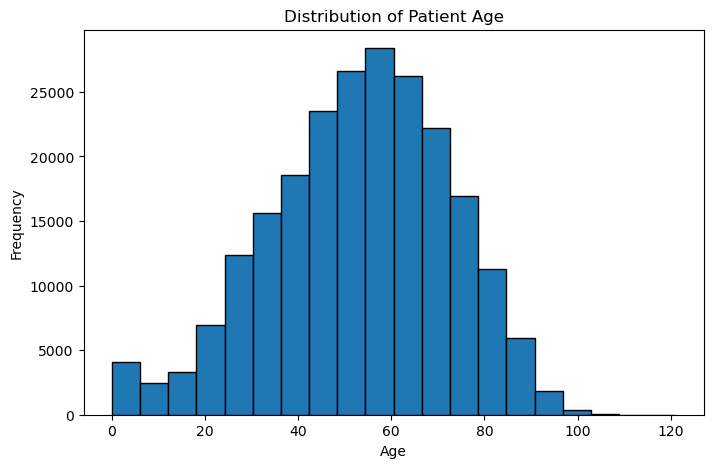

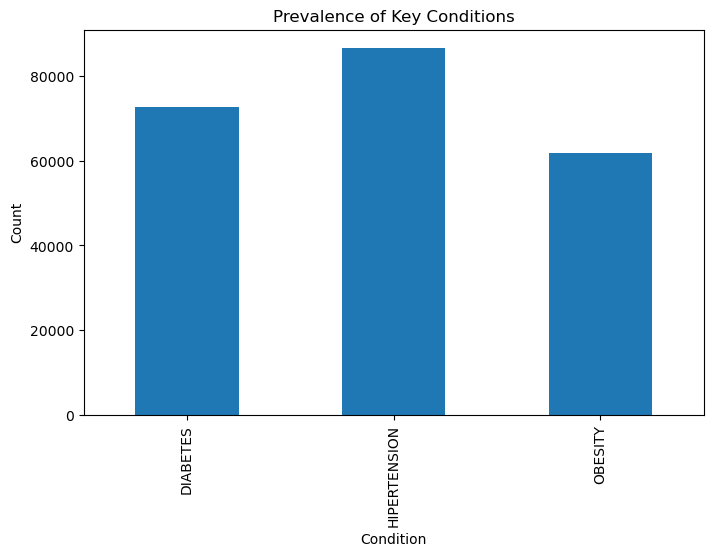

In [7]:
# Exploratory Data Analysis (EDA) - Distribution
print("Dataset Summary:\n", df.describe())

# Age distribution
plt.figure(figsize=(8, 5))
plt.hist(df['AGE'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('../outputs_with_xgboost/age_distribution.png')
plt.show()

# Condition prevalence
condition_counts = df[['DIABETES', 'HIPERTENSION', 'OBESITY']].sum()
condition_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Prevalence of Key Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.savefig('../outputs_with_xgboost/condition_prevalence.png')
plt.show()

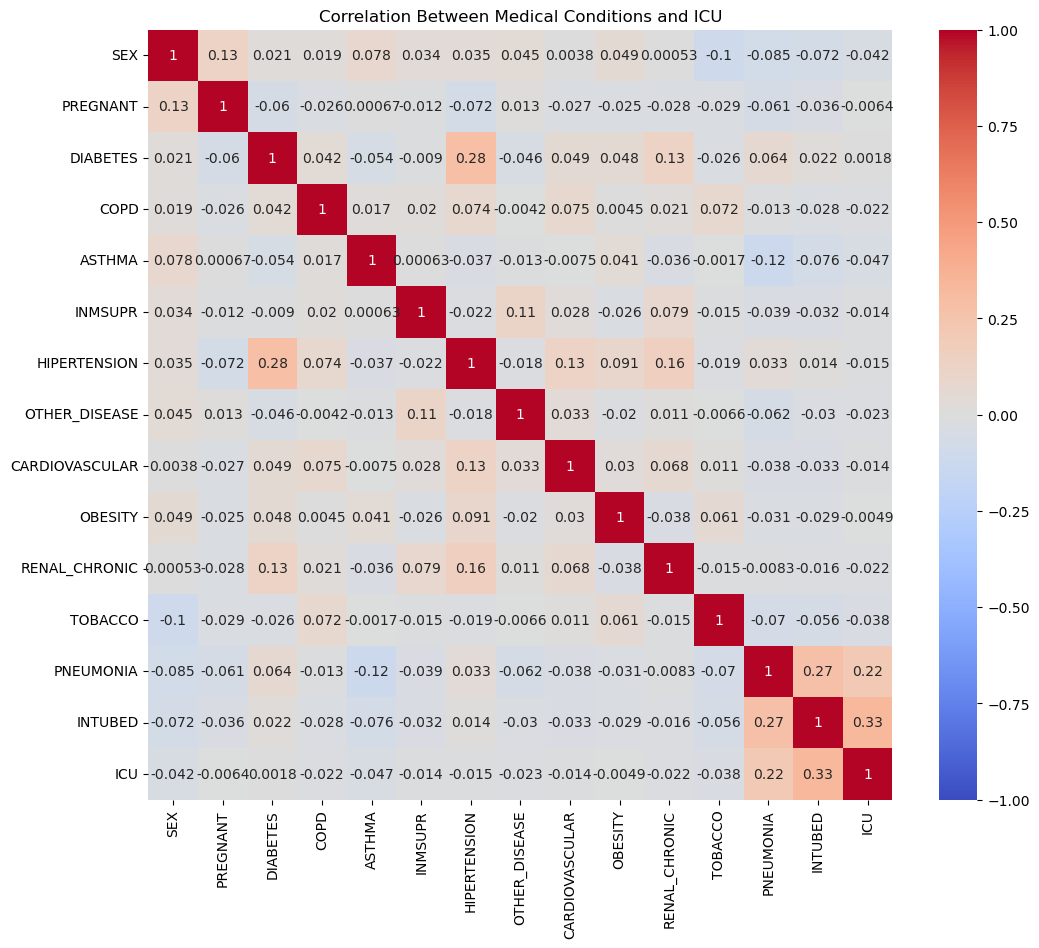

In [8]:
# EDA - Correlation Analysis
correlation_matrix = df[binary_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Medical Conditions and ICU')
plt.savefig('../outputs_with_xgboost/correlation_heatmap.png')
plt.show()

In [9]:
# Feature Engineering
# Add interaction term
df['AGE_PNEUMONIA'] = df['AGE'] * df['PNEUMONIA']

# Verify new features
print(df[['AGE', 'PNEUMONIA', 'AGE_PNEUMONIA']].head())

   AGE  PNEUMONIA  AGE_PNEUMONIA
0   65          1             65
1   72          1             72
2   55          0              0
3   53          0              0
4   68          0              0


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13772\3815987294.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('ICU', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))


RandomizedSearch took 1.1099696159362793 seconds
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Accuracy on Subset: 0.8258377425044092
Subset Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      2124
           1       0.19      0.53      0.28       144

    accuracy                           0.83      2268
   macro avg       0.58      0.69      0.59      2268
weighted avg       0.91      0.83      0.86      2268

Subset AUC-ROC Score: 0.7687522886587153
Accuracy on Full Dataset: 0.8225743849404127
Full Dataset Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90    211401
           1       0.19      0.49      0.27     15325

    accuracy                           0.82    226726
   macro avg       0.57      0.67      0.59    226726
weighted avg       0.91      0.82      

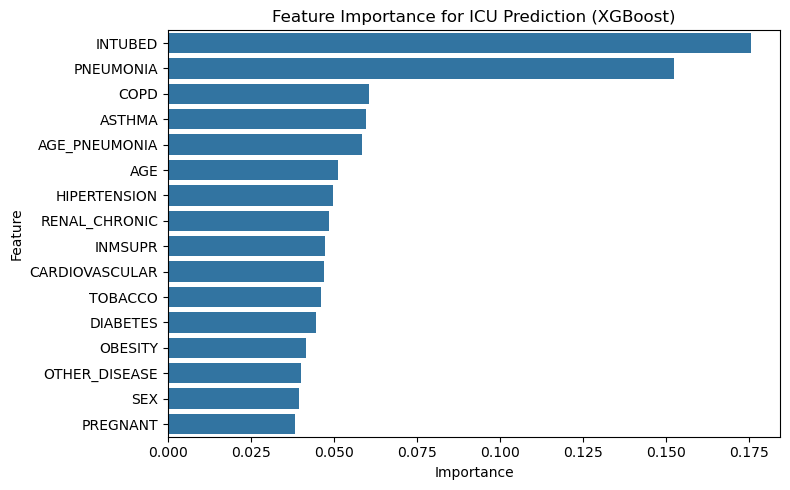

In [16]:
import time

# Prepare and validate data model
# Stratified downsampling to preserve class distribution (5% of each class)
df_sampled = df.groupby('ICU', group_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))

# Features and target
features = ['AGE', 'SEX', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
            'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'PNEUMONIA', 
            'INTUBED', 'AGE_PNEUMONIA']
X = df_sampled[features]
y = df_sampled['ICU']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Define parameter distribution for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
print(f"RandomizedSearch took {time.time() - start_time} seconds")

# Best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate on subset
print("Best Parameters:", random_search.best_params_)
print("Accuracy on Subset:", accuracy_score(y_test, y_pred))
print("Subset Classification Report:\n", classification_report(y_test, y_pred))
print("Subset AUC-ROC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# Prepare full dataset for evaluation
X_full = df[features]
y_full = df['ICU']
y_full_pred = best_model.predict(X_full)

# Evaluate on full dataset
print("Accuracy on Full Dataset:", accuracy_score(y_full, y_full_pred))
print("Full Dataset Classification Report:\n", classification_report(y_full, y_full_pred))
print("Full Dataset AUC-ROC Score:", roc_auc_score(y_full, best_model.predict_proba(X_full)[:, 1]))

# Feature importance for XGBoost
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for ICU Prediction (XGBoost)')
plt.tight_layout()
plt.savefig('../outputs_with_xgboost/feature_importance.png')
plt.show()

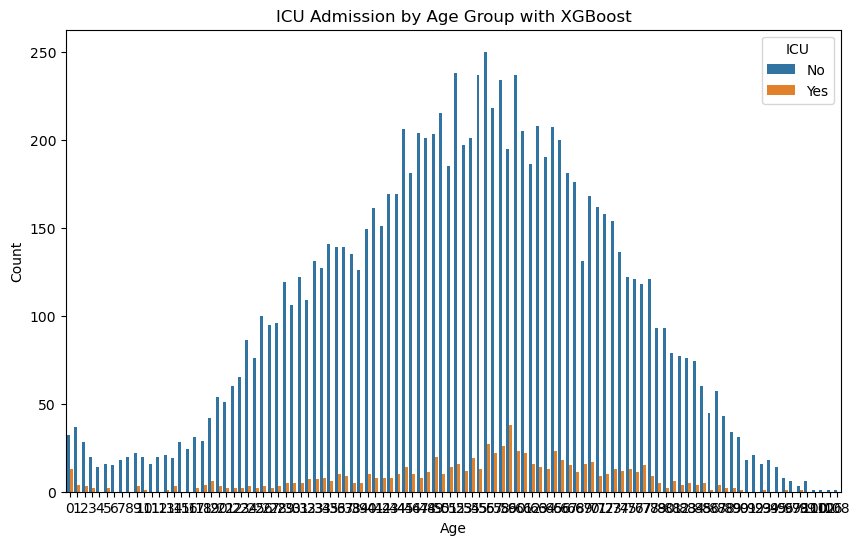

In [14]:
# Additional Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='AGE', hue='ICU', data=df_sampled)
plt.title('ICU Admission by Age Group with XGBoost')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='ICU', labels=['No', 'Yes'])
plt.savefig('../outputs_with_xgboost/icu_by_age.png')
plt.show()

In [17]:
feature_importance.to_csv('../outputs_with_xgboost/feature_importance_xgb.csv', index=False)
print("XGBoost feature importance saved to ../outputs_with_xgboost/feature_importance_xgb.csv")

XGBoost feature importance saved to ../outputs_with_xgboost/feature_importance_xgb.csv


In [19]:
# Assuming rf_accuracy and rf_auc are from Random Forest notebook
rf_accuracy = 0.85  # Replace with actual value from Random Forest output
rf_auc = 0.80       # Replace with actual value from Random Forest output
xgb_accuracy_full = accuracy_score(y_full, y_full_pred)
xgb_auc_full = roc_auc_score(y_full, best_model.predict_proba(X_full)[:, 1])

metrics = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy_full],
    'AUC-ROC': [rf_auc, xgb_auc_full]
})
metrics.to_csv('../outputs_with_xgboost/model_metrics.csv', index=False)
print("Model metrics saved to ../outputs_with_xgboost/model_metrics.csv")

Model metrics saved to ../outputs_with_xgboost/model_metrics.csv
